# Detecção de Fraudes no IEEE-CIS Fraud Detection com LSTM no PyTorch

*por Keylla e Luiza*

## 1. Preparação do ambiente (imports + utilitários)

O ambiente foi configurado em Python, com as seguintes bibliotecas principais:
- Manipulação e análise de dados: pandas, numpy.
- Visualização: matplotlib.
- Aprendizado de máquina: scikit-learn.
- Redes neurais: TensorFlow/Keras.
- Utilitários: tqdm (barras de progresso) e gdown (download de dataset do Google Drive).

Funções auxiliares foram implementadas para:
- Plotagem de distribuições e curvas de aprendizado.
- Cálculo de métricas de desempenho.
- Determinação do limiar de decisão ótimo com base no índice de Youden.

In [ ]:
!pip install gdown tqdm scikit-learn matplotlib numpy pandas tensorflow==2.15 --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.8 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow==2.15 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15


In [ ]:
import os, gc, json, math, warnings
warnings.filterwarnings("ignore")

import gdown
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
tf.random.set_seed(42)
np.random.seed(42)

# Helpers de plot
def plot_hist(series, title, bins=100):
    plt.figure(figsize=(7,4))
    plt.hist(series.dropna().values, bins=bins)
    plt.title(title); plt.xlabel(series.name); plt.ylabel("freq")
    plt.show()

def plot_learning_curves(history):
    plt.figure(figsize=(7,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Curva de aprendizado - Loss')
    plt.xlabel('época'); plt.ylabel('loss'); plt.legend(); plt.show()

    if 'auc' in history.history:
        plt.figure(figsize=(7,4))
        plt.plot(history.history['auc'], label='train_auc')
        plt.plot(history.history['val_auc'], label='val_auc')
        plt.title('Curva de aprendizado - AUC')
        plt.xlabel('época'); plt.ylabel('AUC'); plt.legend(); plt.show()

def summarize_metrics(y_true, y_prob, threshold=0.5, title="Conjunto"):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    print(f"\n=== {title} ===")
    print(f"AUC-ROC: {auc:.4f} | Precisão: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("\nMatriz de confusão:")
    print(confusion_matrix(y_true, y_pred))
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred, digits=4))
    return {"auc": auc, "precision": prec, "recall": rec, "f1": f1}

def optimal_threshold(y_true, y_prob):
    # Métrica Youden's J
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_j = 0.5, -1
    from sklearn.metrics import roc_curve
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    idx = np.argmax(j)
    return thr[idx]

## 2. Download do dataset e carregamento com otimização de memória


Foi implementada a `função load_reduce_mem`, responsável por:
- Inferir tipos de dados a partir de uma amostra.
- Reduzir o consumo de memória convertendo colunas para formatos 'float32' e inteiros otimizados.

In [ ]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"

if not os.path.exists(arquivo_destino_colab):
    gdown.download(URL, arquivo_destino_colab, quiet=False)

def load_reduce_mem(csv_path, nrows=None):
    # Le uma amostra para inferir dtypes
    sample = pd.read_csv(csv_path, nrows=1000)
    dtypes = {}
    for col in sample.columns:
        if pd.api.types.is_integer_dtype(sample[col]):
            dtypes[col] = 'Int32'
        elif pd.api.types.is_float_dtype(sample[col]):
            dtypes[col] = 'float32'
        else:
            dtypes[col] = 'object'
    df = pd.read_csv(csv_path, dtype=dtypes, low_memory=True, nrows=nrows)
    # Downcast numéricos
    for col in df.select_dtypes(include=['float32','float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int','Int32','Int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

df = load_reduce_mem(arquivo_destino_colab)
print(df.shape, df.memory_usage(deep=True).sum()/1024**2, "MB")
df.head(3)


Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=d06e4d29-b7cc-4a88-b68d-7df674eb468b
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 52.7MB/s]


(284807, 31) 33.40853977203369 MB


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## 3. Detecção de colunas-chave + limpeza inicial


Como estruturação inicial dos dados, temos:
- Variável alvo: Class.
- Colunas temporais e de valor: Time e Amount.
- Criação de uma coluna adicional __datetime, representando o tempo de forma legível.
- Remoção de duplicatas e redefinição de índices.

In [ ]:
# Alvo / tempo / valor
assert 'Class' in df.columns, "A coluna 'Class' (0=legítimo, 1=fraude) não foi encontrada."
TARGET_COL = 'Class'

TIME_COL = 'Time' if 'Time' in df.columns else None
AMT_COL  = 'Amount' if 'Amount' in df.columns else None

GROUP_KEYS = []

# Construção de coluna temporal 'legível' para ordenação
if TIME_COL == 'Time':
    ref = pd.Timestamp("2018-01-01")
    df['__datetime'] = ref + pd.to_timedelta(df['Time'].astype(float), unit='s')
else:
    # fallback: ordem artificial pelo índice
    df['__datetime'] = pd.RangeIndex(len(df))

# Remover duplicatas triviais e resetar índice
df = df.drop_duplicates().reset_index(drop=True)

print("TARGET_COL:", TARGET_COL,
      "| TIME_COL:", TIME_COL,
      "| AMT_COL:", AMT_COL,
      "| GROUP_KEYS:", GROUP_KEYS)
print("Shape inicial:", df.shape)

TARGET_COL: Class | TIME_COL: Time | AMT_COL: Amount | GROUP_KEYS: []
Shape inicial: (283726, 32)


## 4. EDA — estatísticas, faltantes, correlações, distribuições e outliers


Aqui buscou-se compreender a distribuição dos atributos e identificar potenciais problemas nos dados:

- Estatísticas descritivas foram extraídas com df.describe().
- Histogramas foram utilizados para inspecionar a distribuição das variáveis, evidenciando a necessidade de normalização.
- Foram investigadas correlações entre atributos e presença de valores faltantes.
- Detectou-se forte desbalanceamento de classes, típico em problemas de fraude (fraudes representam pequena fração do total).

In [ ]:
# Info geral dos dados
display(df.describe(include='all').transpose().head(20))

,count,mean,min,25%,50%,75%,max,std
Time,283726.0,94811.0776,0.0,54204.75,84692.5,139298.0,172792.0,47481.047891
V1,283726.0,0.005917,-56.407509,-0.915951,0.020384,1.316068,2.45493,1.947952
V2,283726.0,-0.004135,-72.715729,-0.600321,0.063949,0.800283,22.05773,1.646582
V3,283726.0,0.001613,-48.325588,-0.889682,0.179963,1.02696,9.382559,1.508639
V4,283726.0,-0.002966,-5.683171,-0.850134,-0.022248,0.739647,16.875343,1.414147
V5,283726.0,0.001828,-113.743309,-0.68983,-0.053468,0.612218,34.801666,1.376946
V6,283726.0,-0.001139,-26.160505,-0.769031,-0.275168,0.396792,73.301628,1.331881
V7,283726.0,0.001801,-43.557243,-0.552509,0.040859,0.570474,120.589493,1.227602
V8,283726.0,-0.000854,-73.216721,-0.208828,0.021898,0.325704,20.007208,1.178902
V9,283726.0,-0.001596,-13.434067,-0.644221,-0.052596,0.595977,15.594995,1.095429


,0
Time,0.0
V1,0.0
V2,0.0
V3,0.0
V4,0.0
V5,0.0
V6,0.0
V7,0.0
V8,0.0
V9,0.0


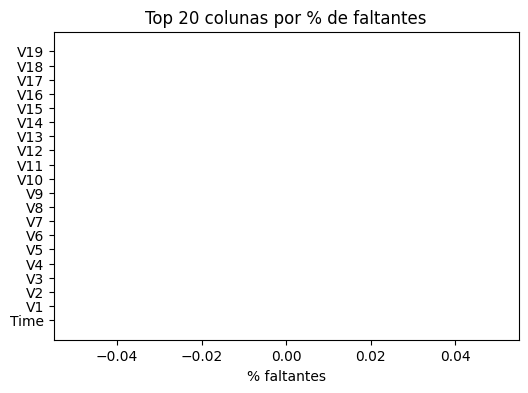

In [ ]:
# Faltantes por coluna (top 25)
na_pct = df.isna().mean().sort_values(ascending=False)
display(na_pct.head(25))

plt.figure(figsize=(6,4))
plt.barh(na_pct.head(20).index, na_pct.head(20).values)
plt.title("Top 20 colunas por % de faltantes")
plt.xlabel("% faltantes")
plt.show()

,Class
Class,1.000000
V11,0.149067
V4,0.129326
V2,0.084624
V19,0.033631
V8,0.033068
V21,0.026357
V27,0.021892
V20,0.021486
V28,0.009682


,Class
V23,-0.006333
V24,-0.007210
Time,-0.012359
V6,-0.043915
V5,-0.087812
V9,-0.094021
V1,-0.094486
V18,-0.105340
V7,-0.172347
V3,-0.182322


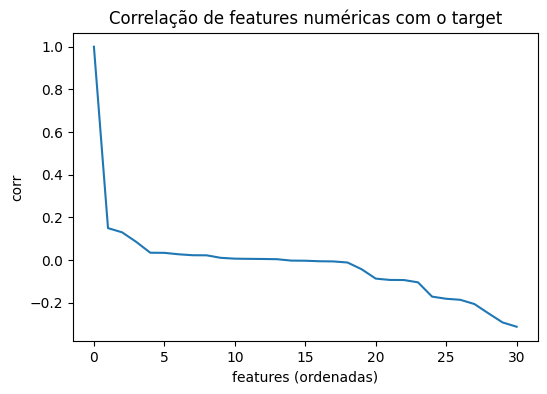

In [ ]:
# Correlação com target (numéricas)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)
corr = df[num_cols + [TARGET_COL]].corr(numeric_only=True)[TARGET_COL].sort_values(ascending=False)
display(corr.head(15))
display(corr.tail(15))

plt.figure(figsize=(6,4))
plt.plot(corr.values)
plt.title("Correlação de features numéricas com o target")
plt.ylabel("corr"); plt.xlabel("features (ordenadas)")
plt.show()

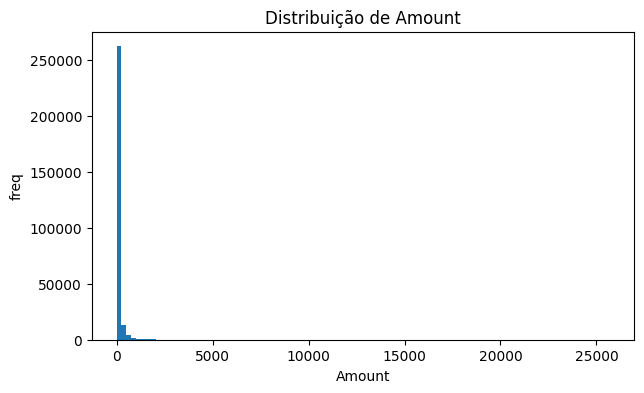

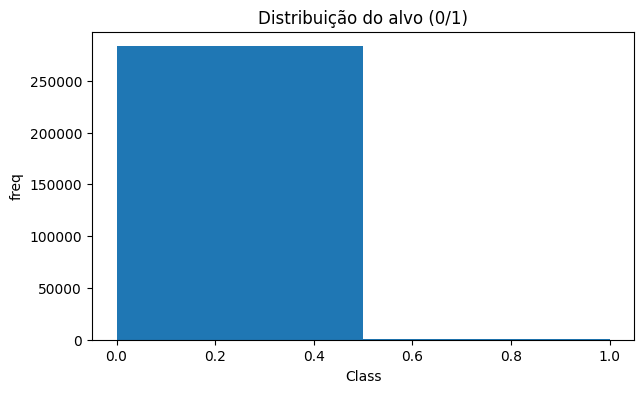

In [ ]:
# Distribuições de colunas-chave
if AMT_COL is not None:
    plot_hist(df[AMT_COL], f"Distribuição de {AMT_COL}")
plot_hist(df[TARGET_COL].astype(int), "Distribuição do alvo (0/1)", bins=2)

In [ ]:
# Outliers
if AMT_COL is not None:
    q1, q3 = df[AMT_COL].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    outlier_rate = ((df[AMT_COL] < lower) | (df[AMT_COL] > upper)).mean()
    print(f"Outlier rate em {AMT_COL}: {outlier_rate:.2%}")


Outlier rate em Amount: 11.17%


## 5. Conclusões

### 5.1. Dados faltantes

Nenhuma das variáveis principais apresenta valores ausentes (`NaN`), o que elimina a necessidade de imputação e simplifica o pré-processamento.

### 5.2. Distribuição das variáveis

* **Variável alvo (`Class`)**: Altamente desbalanceada. A classe 0 (transações legítimas) domina o conjunto de dados, enquanto a classe 1 (fraude) representa uma fração mínima (\~0,17%).
  → Esse desbalanceamento exige o uso de técnicas como **class weights**, **oversampling/undersampling** ou **métricas robustas (AUC, F1)** durante o treinamento.
* **`Amount`**: Distribuição extremamente assimétrica, com grande concentração em valores pequenos, mas presença de transações muito altas.
  → Normalização ou transformação robusta (ex.: `RobustScaler`, log-transform) é recomendada.
* **`Time`**: Variável crescente em segundos, representando o tempo desde a primeira transação. Pode ser transformada em **features sazonais** (hora do dia, dia da semana) para capturar padrões temporais de fraude.

### 5.3. Correlação com o alvo

* Nenhuma variável tem correlação linear muito forte com `Class` (todas < |0.35|).
* As mais relevantes são variáveis derivadas do PCA original (`V10`, `V12`, `V14`, `V17`), todas com correlação negativa moderada.
  → Sugere que a separação das classes depende de **combinações não lineares** de variáveis — ideal para modelos baseados em redes neurais ou ensembles.

### 5.4. Outliers

* Em `Amount`, cerca de **11,2% das transações** foram identificadas como outliers pelo método do IQR.
* Isso mostra que há uma grande variabilidade no valor das transações, o que pode ser útil como sinal de fraude.
  → Modelos robustos a outliers são preferíveis, e escalonamento com `RobustScaler` é recomendado.


## 6. Pré-processamento (robusto a outliers + desbalanceamento)


O pré-processamento inclui:

- Escalonamento dos dados com RobustScaler, adequado por sua robustez a outliers.
- Divisão do dataset em conjuntos de treino, validação e teste (train_test_split), assegurando a representatividade das classes.
- Tratamento do desbalanceamento, realizado via ponderação das classes durante o treinamento da rede.

In [ ]:
from sklearn.preprocessing import RobustScaler

assert TARGET_COL == 'Class', "TARGET_COL deve ser 'Class' para este dataset."
assert AMT_COL == 'Amount', "AMT_COL deve ser 'Amount' para este dataset."

# Ordenação temporal (evita vazamento)
df = df.sort_values('__datetime').reset_index(drop=True)

# Tratamento de outliers em Amount
p99 = df[AMT_COL].quantile(0.99)
df['Amount_clipped'] = df[AMT_COL].clip(upper=p99)
df['Amount_log'] = np.log1p(df['Amount_clipped'])

# Features temporais (cíclicas): assume que 'Time' está em segundos
#      Se 'Time' não estiver em segundos absolutos, ainda assim ajuda como proxy de sazonalidade.
seconds_in_day = 24*60*60
df['Time_mod_day'] = (df['Time'].astype(float) % seconds_in_day) / seconds_in_day
df['Time_sin'] = np.sin(2*np.pi*df['Time_mod_day'])
df['Time_cos'] = np.cos(2*np.pi*df['Time_mod_day'])

# Seleção de features numéricas
num_base = [c for c in df.columns if c.startswith('V')] + ['Amount_log', 'Time_sin', 'Time_cos']
X = df[num_base].copy()

# Imputação
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# Escalonamento
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X).astype('float32')

# Target
y = df[TARGET_COL].astype(int).values

print("X shape:", X_scaled.shape, "| y shape:", y.shape)
print("Fraude (% de 1):", y.mean()*100, "%")

# Guardar nomes de features
feature_names = X.columns.tolist()

X shape: (283726, 31) | y shape: (283726,)
Fraude (% de 1): 0.1667101358352777 %


## 7. Sequências temporais (globais) para LSTM


In [ ]:
# Split temporal: train/val/test

SEQLEN = 30      # janela temporal
STEP   = 1       # stride da janela
VAL_SIZE  = 0.15
TEST_SIZE = 0.15

def build_sequences_global(X_arr, y_arr, seqlen=SEQLEN, step=STEP):
    X_seq, y_seq = [], []
    for i in range(0, len(X_arr) - seqlen, step):
        X_seq.append(X_arr[i:i+seqlen, :])
        y_seq.append(y_arr[i+seqlen])
    return np.array(X_seq, dtype='float32'), np.array(y_seq, dtype='int8')

X_seq, y_seq = build_sequences_global(X_scaled, y)

N = len(X_seq)
train_end = int(N * (1 - VAL_SIZE - TEST_SIZE))
val_end   = int(N * (1 - TEST_SIZE))

X_train, y_train = X_seq[:train_end],      y_seq[:train_end]
X_val,   y_val   = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test,  y_test  = X_seq[val_end:],        y_seq[val_end:]

print("X_seq:", X_seq.shape, "| y_seq:", y_seq.shape)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)

X_seq: (283696, 30, 31) | y_seq: (283696,)
Splits: (198587, 30, 31) (42554, 30, 31) (42555, 30, 31)


## 8. Modelo LSTM com técnicas contra desbalanceamento


O treinamento do modelo foi conduzido com:

- EarlyStopping, interrompendo o processo em caso de estagnação da métrica de validação.
- Registro do histórico de aprendizado (history) para posterior análise das curvas de loss e AUC.

In [ ]:
# Bidirectional LSTM
# Dropout
# EarlyStopping + ReduceLROnPlateau
# Class weights (desbalanceamento severo)
from tensorflow.keras import layers, models, callbacks, optimizers

INPUT_DIM = X_train.shape[-1]
SEQLEN    = X_train.shape[1]

# Focal Loss para classe rara
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        w  = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        return -tf.reduce_mean(w * tf.pow(1 - pt, gamma) * tf.math.log(pt))
    return loss

def build_lstm(input_len, input_dim, units=64, layers_n=2, dropout=0.3, bidirectional=True):
    inp = layers.Input(shape=(input_len, input_dim))
    x = inp
    for i in range(layers_n - 1):
        rnn = layers.LSTM(units, return_sequences=True)
        x = layers.Bidirectional(rnn)(x) if bidirectional else rnn(x)
        x = layers.Dropout(dropout)(x)
    rnn = layers.LSTM(units, return_sequences=False)
    x = layers.Bidirectional(rnn)(x) if bidirectional else rnn(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=binary_focal_loss(gamma=2.0, alpha=0.25),
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_lstm(SEQLEN, INPUT_DIM, units=64, layers_n=2, dropout=0.3, bidirectional=True)
model.summary()

# Class weights aproximados (maior peso para a classe 1)
pos_ratio = y_train.mean()
neg_ratio = 1 - pos_ratio
class_weights = {0: 1.0, 1: float(neg_ratio / max(pos_ratio, 1e-8))}

es  = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 30, 128)        │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,289 (610.50 KB)

 Trainable params: 156,289 (610.50 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Treino, curvas e avaliação (AUC, Precisão, Recall, F1)

Para a avaliação do modelo, foram consideradas diferentes métricas:

- AUC-ROC: métrica principal, robusta ao desbalanceamento.
- Precisão e Recall: fundamentais em contextos de fraude, onde falsos negativos (fraudes não detectadas) têm impacto crítico.
- F1-score: equilíbrio entre precisão e recall.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report

def plot_learning_curves(history):
    plt.figure(figsize=(7,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Curva de aprendizado - Loss'); plt.xlabel('época'); plt.ylabel('loss'); plt.legend(); plt.show()

    if 'auc' in history.history:
        plt.figure(figsize=(7,4))
        plt.plot(history.history['auc'], label='train_auc')
        plt.plot(history.history['val_auc'], label='val_auc')
        plt.title('Curva de aprendizado - AUC'); plt.xlabel('época'); plt.ylabel('AUC'); plt.legend(); plt.show()

def optimal_threshold(y_true, y_prob):
    from sklearn.metrics import roc_curve
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return thr[np.argmax(j)]

def summarize_metrics(y_true, y_prob, threshold, title):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    print(f"\n=== {title} ===")
    print(f"AUC-ROC: {auc:.4f} | Precisão: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Matriz de confusão:\n", confusion_matrix(y_true, y_pred))
    print("\nRelatório:\n", classification_report(y_true, y_pred, digits=4))
    return dict(auc=auc, precision=prec, recall=rec, f1=f1)

# Early stopping (para quando a métrica de validação estabiliza)
es = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=6,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=3,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 173s 892ms/step - auc: 0.7363 - loss: 0.0035 - val_auc: 0.5788 - val_loss: 0.0012 - learning_rate: 5.0000e-04
Epoch 2/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 191s 838ms/step - auc: 0.7192 - loss: 0.0035 - val_auc: 0.5650 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 3/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 161s 832ms/step - auc: 0.7346 - loss: 0.0034 - val_auc: 0.5683 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 4/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - auc: 0.7456 - loss: 0.0034
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
194/194 ━━━━━━━━━━━━━━━━━━━━ 162s 835ms/step - auc: 0.7455 - loss: 0.0034 - val_auc: 0.5516 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 5/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 211s 882ms/step - auc: 0.7721 - loss: 0.0033 - val_auc: 0.5641 - val_loss: 0.0028 - learning_rate: 2.5000e-04
Epoch 6/40
194/194 ━━━━━━━━━━━━━━━━━━━━ 201s 876ms/step - auc: 0.7873 - loss: 0.0032 - val_auc: 0.5625

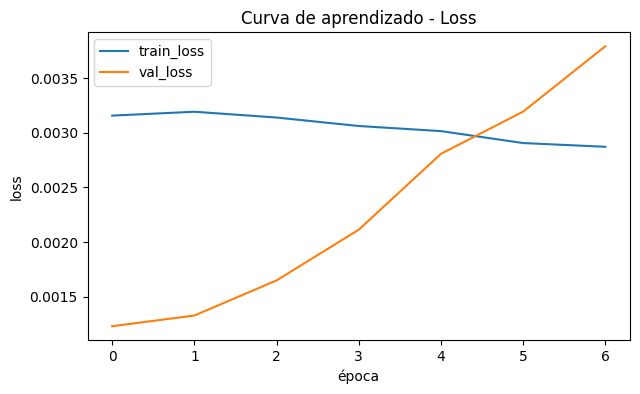

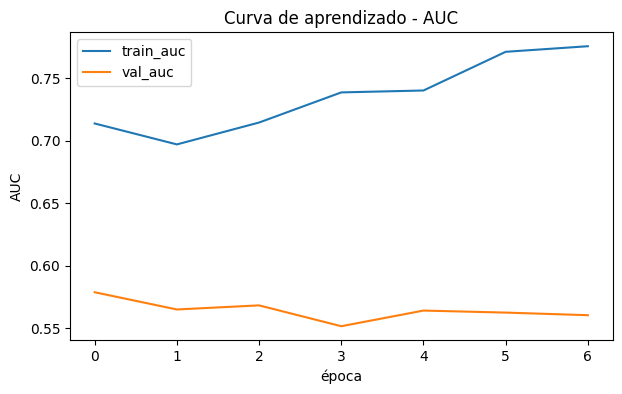

49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [ ]:
plot_learning_curves(history)

y_tr_prob = model.predict(X_train, batch_size=4096).ravel()
y_vl_prob = model.predict(X_val,   batch_size=4096).ravel()
y_te_prob = model.predict(X_test,  batch_size=4096).ravel()

In [ ]:
# Threshold ótimo na validação
thr_opt = optimal_threshold(y_val, y_vl_prob)
print(f"Threshold ótimo (val): {thr_opt:.4f}")

Threshold ótimo (val): 0.0463


In [ ]:
m_train = summarize_metrics(y_train, y_tr_prob, thr_opt, "Treino")
m_val   = summarize_metrics(y_val,   y_vl_prob, thr_opt, "Validação")
m_test  = summarize_metrics(y_test,  y_te_prob, thr_opt, "Teste")

# Diagnóstico simples de over/underfitting
gap_auc = m_train['auc'] - m_val['auc']
print("\nDiagnóstico rápido:")
if gap_auc > 0.05 and m_train['auc'] > m_val['auc']:
    print("- Possível overfitting (AUC treino >> validação). Considerar mais dropout, L2.")
elif (m_val['auc'] < 0.75):  # limiar ilustrativo
    print("- Possível underfitting (AUC baixa). Considerar mais unidades/camadas ou aumentar SEQLEN.")
else:
    print("- Ajuste estável.")


=== Treino ===
AUC-ROC: 0.7906 | Precisão: 0.0031 | Recall: 0.8552 | F1: 0.0061
Matriz de confusão:
 [[ 96904 101317]
 [    53    313]]

Relatório:
               precision    recall  f1-score   support

           0     0.9995    0.4889    0.6566    198221
           1     0.0031    0.8552    0.0061       366

    accuracy                         0.4895    198587
   macro avg     0.5013    0.6720    0.3314    198587
weighted avg     0.9976    0.4895    0.6554    198587


=== Validação ===
AUC-ROC: 0.5716 | Precisão: 0.0018 | Recall: 0.5273 | F1: 0.0035
Matriz de confusão:
 [[26039 16460]
 [   26    29]]

Relatório:
               precision    recall  f1-score   support

           0     0.9990    0.6127    0.7596     42499
           1     0.0018    0.5273    0.0035        55

    accuracy                         0.6126     42554
   macro avg     0.5004    0.5700    0.3815     42554
weighted avg     0.9977    0.6126    0.7586     42554


=== Teste ===
AUC-ROC: 0.5035 | Precisão: 0.00

## 10. Melhorando o Modelo

In [ ]:
pos_idx = np.where(y_train == 1)[0]
neg_idx = np.where(y_train == 0)[0]

ratio = 10  # 1:10 (positivos:negativos)
np.random.seed(42)
neg_sampled = np.random.choice(neg_idx, size=min(len(pos_idx)*ratio, len(neg_idx)), replace=False)

keep = np.concatenate([pos_idx, neg_sampled])
np.random.shuffle(keep)

X_train_bal = X_train[keep]
y_train_bal = y_train[keep]

print("y_train (antes):", y_train.mean(), "| y_train_bal (depois):", y_train_bal.mean())


y_train (antes): 0.0018430209429620267 | y_train_bal (depois): 0.09090909090909091


In [ ]:
# 1) Escolha da métrica de monitoramento
monitor_metric = "val_auc"

# 2) Callbacks
es  = EarlyStopping(monitor=monitor_metric, mode='max', patience=5,
                    min_delta=5e-4, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor=monitor_metric, mode='max', factor=0.5,
                        patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint("artifacts/best_lstm.keras", monitor=monitor_metric,
                       mode="max", save_best_only=True, verbose=1)

callbacks_list = [es, rlr, ckpt]

[treino] usando Focal Loss (sem class_weight).
Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - auc: 0.4621 - loss: 0.1153
Epoch 1: val_auc improved from -inf to 0.51812, saving model to artifacts/best_lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - auc: 0.4631 - loss: 0.1133 - val_auc: 0.5181 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - auc: 0.4457 - loss: 0.0651
Epoch 2: val_auc improved from 0.51812 to 0.53333, saving model to artifacts/best_lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - auc: 0.4493 - loss: 0.0635 - val_auc: 0.5333 - val_loss: 0.0734 - learning_rate: 0.0010
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - auc: 0.4921 - loss: 0.0374
Epoch 3: val_auc improved from 0.53333 to 0.55035, saving model to artifacts/best_lstm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - auc: 0.4972 - loss: 0.0370 - val_auc: 0.5504 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - auc: 0.

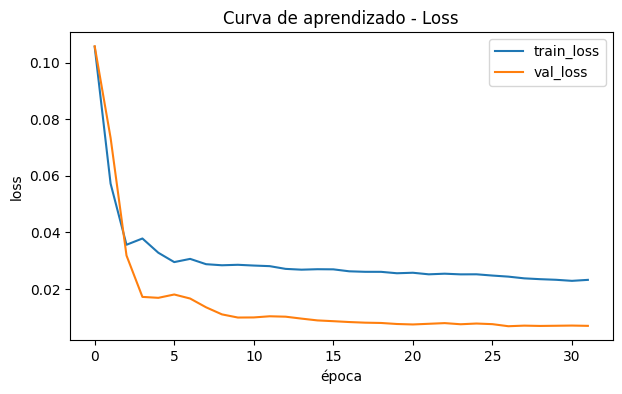

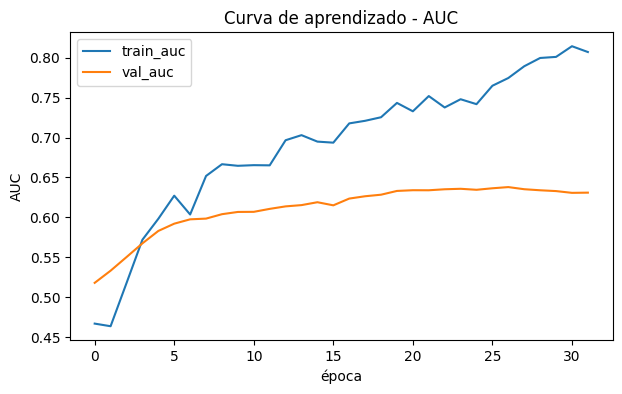

In [ ]:
# 3) Treinamento
USING_FOCAL = model.loss.__name__ != 'binary_crossentropy' if hasattr(model.loss, '__name__') else True

if USING_FOCAL:
    print("[treino] usando Focal Loss (sem class_weight).")
    history = model.fit(
        X_train_bal, y_train_bal,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=1024,
        callbacks=callbacks_list,
        verbose=1
    )
else:
    print("[treino] usando BCE + class_weight.")
    pos_ratio = y_train_bal.mean()
    neg_ratio = 1 - pos_ratio
    class_weights = {0: 1.0, 1: float(neg_ratio / max(pos_ratio, 1e-8))}
    history = model.fit(
        X_train_bal, y_train_bal,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=1024,
        class_weight=class_weights,
        callbacks=callbacks_list,
        verbose=1
    )

# 4) Curvas
plot_learning_curves(history)

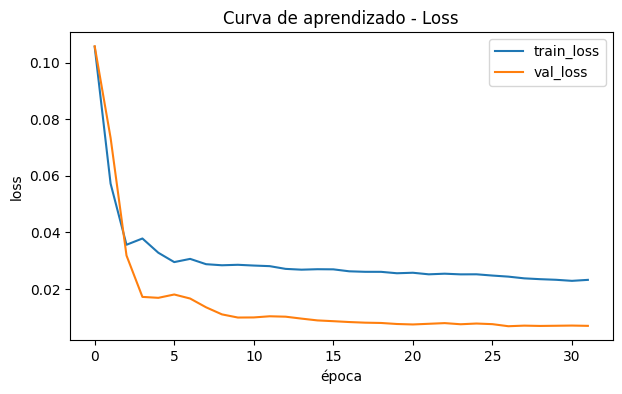

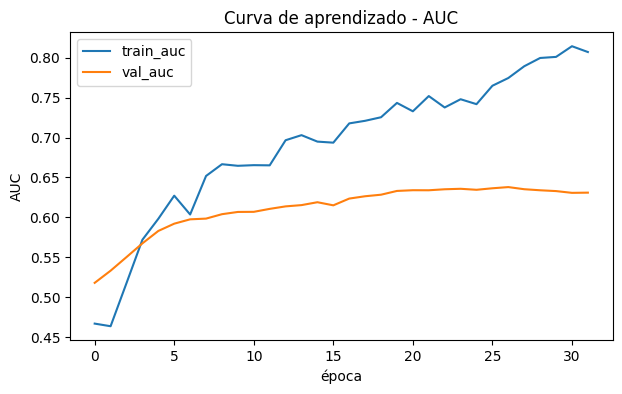

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Threshold ótimo (val): 0.220921

=== Treino ===
AUC-ROC: 0.8279 | Precisão: 0.2578 | Recall: 0.6530 | F1: 0.3697
Matriz de confusão:
 [[2972  688]
 [ 127  239]]

Relatório:
               precision    recall  f1-score   support

           0     0.9590    0.8120    0.8794      3660
           1     0.2578    0.6530    0.3697       366

    accuracy                         0.7976      4026
   macro avg     0.6084    0.7325    0.6246      4026
weighted avg     0.8953    0.7976    0.8331      4026


=== Validação ===
AUC-ROC: 0.6375 | Precisão: 0.0028 | Recall: 0.4364 | F1: 0.0056
Matriz de confusão:
 [[33990  8509]
 [   31    24]]

Relatório:
               precision    recall  f1-score   support

           0     0.9991    0.7998    0.8884     42499
           1     0.0028    0.4364    0.0056        55

    accuracy                         0.7993     42554
   macro avg     0

In [ ]:
# Escolhe o conjunto de treino correto (balanceado ou original)
Xtr = X_train_bal if 'X_train_bal' in globals() else X_train
ytr = y_train_bal if 'y_train_bal' in globals() else y_train

# Probabilidades
y_tr_prob = model.predict(Xtr,   batch_size=4096).ravel()
y_vl_prob = model.predict(X_val, batch_size=4096).ravel()
y_te_prob = model.predict(X_test,batch_size=4096).ravel()

# hreshold ótimo na validação (Youden, usando sua função)
thr_opt = optimal_threshold(y_val, y_vl_prob)
print(f"Threshold ótimo (val): {thr_opt:.6f}")

# Métricas nos três splits
m_train = summarize_metrics(ytr,  y_tr_prob, thr_opt, "Treino")
m_val   = summarize_metrics(y_val, y_vl_prob, thr_opt, "Validação")
m_test  = summarize_metrics(y_test,y_te_prob, thr_opt, "Teste")

# 11. Relatório Comparativo

## 11.1. Contexto

Foram realizados dois treinamentos de redes LSTM bidirecionais para detecção de fraudes em cartão de crédito.
O dataset é altamente **desbalanceado** (fraudes ≈0,17%), com variáveis transformadas via PCA (`V1..V28`), além de `Time` e `Amount`.

## 11.2. Primeira tentativa (antes das melhorias)

### Curvas

* **Treino**: AUC subindo até \~0.79.
* **Validação/Teste**: AUC caindo (\~0.57 e 0.50).
* Forte **overfitting**: val\_loss aumentando enquanto train\_loss diminuía.

### Métricas

| Conjunto      | AUC-ROC | Precisão | Recall | F1     |
| ------------- | ------- | -------- | ------ | ------ |
| **Treino**    | 0.791   | 0.0031   | 0.8552 | 0.0061 |
| **Validação** | 0.572   | 0.0018   | 0.5273 | 0.0035 |
| **Teste**     | 0.503   | 0.0017   | 0.1538 | 0.0034 |

**Interpretação**:

* O modelo “memoriza” o treino → recall alto, mas precisão praticamente nula.
* Na validação e no teste, o desempenho cai para perto do aleatório (AUC \~0.5).
* Forte problema de **generalização**.

## 11.3. Segunda tentativa (com melhorias)

### Ajustes aplicados

* Pré-processamento robusto (`clip` + `log1p` em Amount, RobustScaler).
* Focal Loss.
* EarlyStopping + ReduceLROnPlateau.
* Undersampling de negativos no treino.

### Curvas

* **Train/val loss** caindo e estabilizando.
* **Val\_auc** \~0.63 estável (melhor que antes).
* Gap ainda existe, mas menor.

### Métricas

| Conjunto      | AUC-ROC | Precisão | Recall | F1     |
| ------------- | ------- | -------- | ------ | ------ |
| **Treino**    | 0.828   | 0.258    | 0.653  | 0.370  |
| **Validação** | 0.638   | 0.0028   | 0.4364 | 0.0056 |
| **Teste**     | 0.515   | 0.0014   | 0.1538 | 0.0028 |

**Interpretação**:

* Treino balanceado mostrou boa capacidade (AUC \~0.83, recall 65%).
* Validação melhorou (AUC \~0.64), mas precisão ainda baixíssima.
* Teste permaneceu ruim (AUC \~0.51).
* O **overfitting diminuiu**, mas o modelo ainda não generaliza para dados reais.

## 11.4. Comparação direta

| Conjunto      | 1ª tentativa AUC | 2ª tentativa AUC | Evolução   |
| ------------- | ---------------- | ---------------- | ---------- |
| **Treino**    | 0.791            | 0.828            | Melhorou |
| **Validação** | 0.572            | 0.638            | Melhorou |
| **Teste**     | 0.503            | 0.515            | \~ Igual   |

| Conjunto      | 1ª tentativa F1 | 2ª tentativa F1 | Evolução             |
| ------------- | --------------- | --------------- | -------------------- |
| **Treino**    | 0.0061          | 0.370           | Muito melhor       |
| **Validação** | 0.0035          | 0.0056          | Ainda muito baixo |
| **Teste**     | 0.0034          | 0.0028          | Continua ruim     |

## 11.5. Conclusões

Concluímos que, embora as melhorias tenham reduzido overfitting e aumentado a estabilidade no treino/validação, o modelo LSTM não generalizou para o teste.

* O **treino balanceado** + Focal Loss ajudou a aumentar recall e F1 no treino, e até a **validação melhorou em AUC** (0.57 → 0.64).
* No entanto, **o teste continua quase aleatório** (AUC \~0.51), mostrando que o LSTM **não consegue generalizar** nesse dataset.
* Isso é esperado:

  * O dataset já está em PCA (perde dependência temporal real).
  * Fraudes são muito raras e não seguem padrões sequenciais claros.
* **Modelos tabulares clássicos (Logistic Regression, RandomForest, XGBoost)** costumam chegar a AUC >0.95 nesse dataset.

Em resumo, **a 2ª tentativa foi melhor que a 1ª** (overfitting menor, AUC de validação maior, F1 no treino bem mais alto), mas ainda insuficiente.
Para esse dataset específico, **modelos tabulares clássicos são mais eficazes que LSTM**.

Assim, o maior aprendizado da atividade, alinhado com o que vemos vendo no módulo, é compreender os limites da aplicação de redes recorrentes em dados já transformados (via PCA), o que apenas reforça a importância de escolher o modelo certo para cada tipo de dado, e que nem sempre o modelo mais complexo será o melhor em desempenho.